# *TRABAJO FINAL: CLASIFICACIÓN DE SUELOS CON MACHINE LEARNING*
**Integrantes:** Flor Castillo, Fabio García y Valeria Falla  
**Curso:** Análisis Espacial  
**Especialidad:** Geografía y Medio Ambiente  
**Jefe de prácticas:** Yonatan Tarazona



## 1.0 LIBRERÍAS
---------------------------------------------------------------------------------------

In [1]:
import rasterio
import numpy as np
from scikeo.mla import MLA
from scikeo.plot import plotRGB
import matplotlib.pyplot as plt
from dbfread import DBF
import matplotlib as mpl
import pandas as pd

## 2.0 DEFINIR ENTRADAS DEL MODELO DE CLASIFICACIÓN 
---------------------------------------------------------------------------------------

Para la realizar la clasificación mediante el paquete `scikeo.mla` se necesitan dos **datos de entrada**: 
1. Una única **imagen** con todas las bandas a utilizar (un stack)
2. El **dbf** de un shape de puntos con las áreas de entrenamiento

##### Imagen satelital
Previamente se descargó la imagén satelital Sentinel-2 proporcionada con una resolución de 20m recortada al área de interés. Dicha imagen contenía **6 bandas**: B2 (Blue), B3 (Green), B4 (Red), B8 (NIR), B11 (SWIR1), B12 (SWIR2)  

Luego se realizaron **5 índices** en Qgis para mejorar la clasificación:  
- Normalized Difference Vegetation Index ([NDVI](https://www.mdpi.com/2072-4292/14/7/1562/htm))
- Normlaized Difference Snow Index ([NDSI](https://www.mdpi.com/2072-4292/14/7/1562/htm))
- Normalized Difference Snow Ice Index ([NDSII](https://www.researchgate.net/publication/248978081_ASTER_ratio_indices_for_supraglacial_terrain_mapping))
- Normalized Water Index ([NDWI](https://www.cambridge.org/core/services/aop-cambridge-core/content/view/4FB41EE35C2FF418EAE58E5BEB4F607D/S0260305500000021a.pdf/a-hierarchical-knowledge-based-classification-for-glacier-terrain-mapping-a-case-study-from-kolahoi-glacier-kashmir-himalaya.pdf))
- Bare Soil Index ([BSI](https://www.mdpi.com/2073-445X/10/3/231/htm))

Posteriormente en ArcGis se hizo un stack de la imagen y los índices a fin de obtener una **imagen 
final con las 11 bandas** 

##### Áreas de entrenamiento
Primero se creo un **shape de puntos** con las áreas de entrenamiento (**517**) para 8 coberturas de suelo: 
- Áreas Urbanas 
- Vegetación Natural 
- Áreas Agrícolas 
- Bofedales
- Suelo desnudo 
- Área glaciar
- Cuerpos de Agua 
- Zonas mineras 

Luego se **extrajo la información de cada una de las bandas** para esos puntos

Tanto el stack de la imagen satelital como los dbfs utilizados en este script pueden descargarse [aquí](https://drive.google.com/drive/folders/13quvTij64_KZ-hOga1PRDX_q2uzfWyh1?usp=share_link)

In [2]:
# Stack de la imagen Sentinel proporcionada con las 8 bandas y 5 índices 
path_raster = r"C:\Users\vale5\OneDrive\Documentos\Universidad\2022-2\Analisis\TRABF_ML_DL\Data\raster\compi2.tif"
img = rasterio.open(path_raster)

# Dbf del shape de puntos que servirá como áreas de entrenamiento
# Este primer dbf tiene 8 categorías de suelo áreas urbanas   
path_endm = r"C:\Users\vale5\OneDrive\Documentos\Universidad\2022-2\Analisis\TRABF_ML_DL\Data\vector\AdEpuntos.dbf"
endm = DBF(path_endm)

In [3]:
# Información del dbf
df = pd.DataFrame(iter(endm))
df.head()

,Clases,IMG_AOI_6B,IMG_AOI__1,IMG_AOI__2,IMG_AOI__3,IMG_AOI__4,IMG_AOI__5,NDVI,NDSI,NDSII,NDWI_,BSI
0,4.0,1766.0,1795.0,1774.0,4318.0,3392.0,2254.0,0.41760,-0.30789,-0.41273,-0.41273,-0.08160
1,4.0,1676.0,1681.0,1585.0,3514.0,2616.0,1891.0,0.37831,-0.21759,-0.35284,-0.35284,-0.10531
2,4.0,1761.0,1768.0,1756.0,3472.0,3494.0,2474.0,0.32823,-0.32801,-0.32519,-0.32519,0.00162
3,4.0,1670.0,1660.0,1643.0,3218.0,2705.0,1953.0,0.32401,-0.23940,-0.31939,-0.31939,-0.05847
4,4.0,1683.0,1699.0,1622.0,3238.0,2623.0,1883.0,0.33251,-0.21379,-0.31173,-0.31173,-0.07375


## 3.0 CLASIFICACIÓN
-------------------------------------------------------------------------

Para la clasificación se utilizó inicialmente el algoritmo de **Random Forest (RF)** de `scikeo.mla`.  
Posteriormente se hicieron **distintos intentos** modificando: 
- el algoritmo a **Suport Vector Machine (SVM)**
- las áreas de entrenamiento y cantidad de cobertura de suelos
- las áreas de entrenamiento en las coberturas donde había confusión  

Por último, se realizaron **iteraciones** con el algoritmo y las áreas de entrenamiento que tenían mejor presición e índice Kappa

## 3.1 Intento 1   ----------------------------------------------------------

### Clasificación con RF

In [4]:
inst = MLA(image = img, endmembers = endm)

In [5]:
MLA??

In [12]:
import warnings 
warnings.filterwarnings("ignore")
rf_class = inst.RF(training_split = 0.7)

### Resultados

In [13]:
rf_class.keys()

dict_keys(['Overall_Accuracy', 'Kappa_Index', 'Confusion_Matrix', 'Classification_Map', 'Image'])

In [14]:
print('RESULTADOS RF - 8 COBERTURAS DE SUELO', '\n' 'Overall Accuracy:', rf_class.get('Overall_Accuracy'),'\n' 'Kappa Index:', rf_class.get('Kappa_Index'))

RESULTADOS RF - 8 COBERTURAS DE SUELO 
Overall Accuracy: 0.8076923076923077 
Kappa Index: 0.777925405713201


In [15]:
rf_class.get('Confusion_Matrix')

,0,1,2,3,4,5,6,7,Total,Users_Accuracy,Commission
0,4.000000,0.000000,0.000000,0.000000,4.000000,0.0,0.0,5.000000,13.0,30.769231,69.230769
1,0.000000,23.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,23.0,100.000000,0.000000
2,3.000000,0.000000,17.000000,2.000000,0.000000,0.0,1.0,0.000000,23.0,73.913043,26.086957
3,0.000000,1.000000,4.000000,9.000000,0.000000,0.0,0.0,0.000000,14.0,64.285714,35.714286
4,2.000000,0.000000,1.000000,0.000000,25.000000,0.0,1.0,1.000000,30.0,83.333333,16.666667
5,0.000000,0.000000,0.000000,0.000000,0.000000,19.0,0.0,0.000000,19.0,100.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,18.0,1.000000,19.0,94.736842,5.263158
7,4.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,11.000000,15.0,73.333333,26.666667
Total,13.000000,24.000000,22.000000,11.000000,29.000000,19.0,20.0,18.000000,NaN,NaN,NaN
Producer_Accuracy,30.769231,95.833333,77.272727,81.818182,86.206897,100.0,90.0,61.111111,NaN,NaN,NaN


Los resultados son buenos, pero existen **problemas en la clasificación de las áreas urbanas** (categoría 0 en la matriz de confusión) y **zonas mineras** (categoría 7)

### Visualizar imagen RGB y clasificación

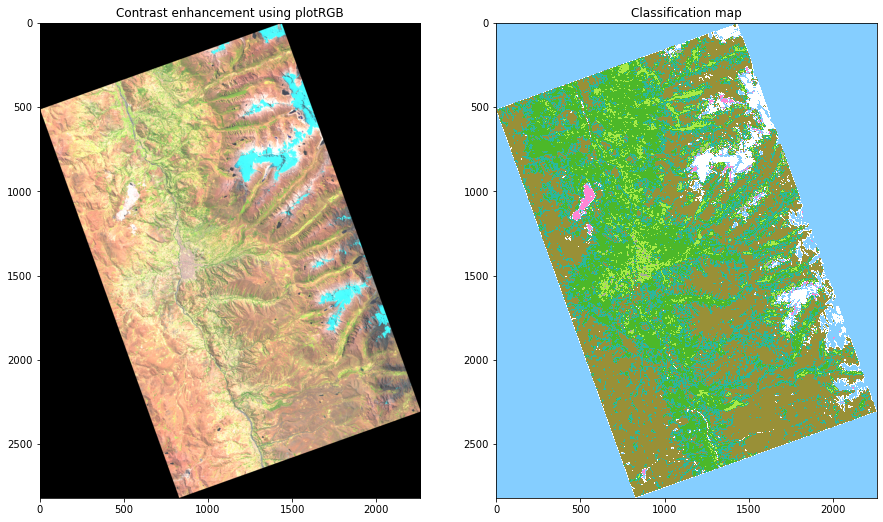

In [16]:
# Definición de la paleta de colores
palette = mpl.colors.ListedColormap(["#A3A3A3","#A9EB47","#4CB829", "#29B89E", "#999037", "#FFFFFF", "#85CEFF", "#FF85D4"])
# Let´s plot
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 9))
# Imagen inicial
plotRGB(img, title = 'Contrast enhancement using plotRGB', ax = axes[0])
# Imagen de la clasificación
axes[1].imshow(rf_class.get('Classification_Map'), cmap = palette)
axes[1].set_title("Classification map")
axes[1].grid(False)


Al comparar ambas imágenes, se observa que hubo **problemas en la clasficación de las zonas mineras** (se clasifican como zona urbana) y parte de las **morrenas glaciares** se clasifica como zonas mineras

## 3.2 Intento 2 ----------------------------------------------------------

### Clasificación con SVM

In [22]:
svm_class = inst.SVM(training_split = 0.7)

In [23]:
print('RESULTADOS SVM - 8 COBERTURAS DE SUELO', '\n' 'Overall Accuracy:', svm_class.get('Overall_Accuracy'),'\n' 'Kappa Index:', svm_class.get('Kappa_Index'))

RESULTADOS SVM - 8 COBERTURAS DE SUELO 
Overall Accuracy: 0.75 
Kappa Index: 0.7060017396346767


In [24]:
svm_class.get('Confusion_Matrix')

,0,1,2,3,4,5,6,7,Total,Users_Accuracy,Commission
0,6.000000,0.000000,0.000000,0.0,4.000000,0.0,0.000000,1.0,11.0,54.545455,45.454545
1,0.000000,12.000000,3.000000,1.0,0.000000,0.0,0.000000,0.0,16.0,75.000000,25.000000
2,2.000000,0.000000,11.000000,2.0,2.000000,0.0,1.000000,0.0,18.0,61.111111,38.888889
3,0.000000,1.000000,2.000000,12.0,0.000000,0.0,0.000000,0.0,15.0,80.000000,20.000000
4,2.000000,0.000000,2.000000,0.0,34.000000,0.0,4.000000,1.0,43.0,79.069767,20.930233
5,0.000000,0.000000,0.000000,0.0,0.000000,17.0,0.000000,0.0,17.0,100.000000,0.000000
6,0.000000,0.000000,0.000000,0.0,1.000000,0.0,13.000000,2.0,16.0,81.250000,18.750000
7,3.000000,0.000000,1.000000,0.0,0.000000,0.0,4.000000,12.0,20.0,60.000000,40.000000
Total,13.000000,13.000000,19.000000,15.0,41.000000,17.0,22.000000,16.0,NaN,NaN,NaN
Producer_Accuracy,46.153846,92.307692,57.894737,80.0,82.926829,100.0,59.090909,75.0,NaN,NaN,NaN


## 3.3 Intento 3 ----------------------------------------------------------

### Clasificación con RF modificando áreas de entrenamiento y agregando una cobertura de suelo

Como el algoritmo de **RF dio los mejores resultados**, pero existían problemas en la clasificación de áreas urbanas y zonas mineras y morrenas glaciares se modificaron las áreas de entrenamiento y se agregró la cobertura de **morrenas**. Por tanto, el shape pasó a tener **559 áreas de entrenamiento y 9 coberturas**

In [25]:
# Dbf del nuevo shape de áreas de entrenamiento (9 coberturas)
path_endm2 = r"C:\Users\vale5\OneDrive\Documentos\Universidad\2022-2\Analisis\TRABF_ML_DL\Data\vector\AdEpuntos2.dbf"
endm2 = DBF(path_endm2)

In [26]:
inst = MLA(image = img, endmembers = endm2)
import warnings 
warnings.filterwarnings("ignore")
rf_class2 = inst.RF(training_split = 0.7)
print('RESULTADOS RF - 9 COBERTURAS DE SUELO', '\n' 'Overall Accuracy:', rf_class2.get('Overall_Accuracy'),'\n' 'Kappa Index:', rf_class2.get('Kappa_Index'))

RESULTADOS RF - 9 COBERTURAS DE SUELO 
Overall Accuracy: 0.8214285714285714 
Kappa Index: 0.7887058231668973


In [27]:
rf_class2.get('Confusion_Matrix')

,0,1,2,3,4,5,6,7,8,Total,Users_Accuracy,Commission
0,9.000000,0.0,0.0,0.0,0.000000,0.0,1.0,2.000000,0.000000,12.0,75.000000,25.000000
1,0.000000,18.0,1.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,19.0,94.736842,5.263158
2,0.000000,0.0,18.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,18.0,100.000000,0.000000
3,0.000000,0.0,1.0,9.0,0.000000,0.0,0.0,0.000000,0.000000,10.0,90.000000,10.000000
4,3.000000,0.0,4.0,0.0,42.000000,0.0,7.0,0.000000,1.000000,57.0,73.684211,26.315789
5,0.000000,0.0,0.0,0.0,0.000000,14.0,0.0,0.000000,0.000000,14.0,100.000000,0.000000
6,0.000000,0.0,0.0,0.0,1.000000,0.0,12.0,0.000000,1.000000,14.0,85.714286,14.285714
7,5.000000,0.0,1.0,0.0,0.000000,0.0,0.0,12.000000,1.000000,19.0,63.157895,36.842105
8,0.000000,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,4.000000,5.0,80.000000,20.000000
Total,17.000000,18.0,25.0,9.0,44.000000,14.0,20.0,14.000000,7.000000,NaN,NaN,NaN


Si bien disminuyeron los problemas en la clasificación de las áreas mineras y urbanas se disminuyó la precisión en otras coberturas y la clasificación de las morrenas también presentó problemas... 

## 3.4 Intento 4 ----------------------------------------------------------

### Clasificación con RF modificando áreas de entrenamiento

Para salir de dudas probamos eliminando la cobertura de morrenas y utilizando solo el shape con las áreas de entrenamiento modificadas (**539 áreas de entrenamiento y 8 categorías**)

In [28]:
# Intento con áreas de entrenamiento modificadas para las 8 categorías iniciales"
path_endm3 = r"C:\Users\vale5\OneDrive\Documentos\Universidad\2022-2\Analisis\TRABF_ML_DL\Data\vector\AdEpuntos3.dbf"
endm3 = DBF(path_endm3)
inst = MLA(image = img, endmembers = endm3)
import warnings 
warnings.filterwarnings("ignore")
rf_class3 = inst.RF(training_split = 0.7)
print('RESULTADOS RF3 - 8 COBERTURAS DE SUELO', '\n' 'Overall Accuracy:', rf_class3.get('Overall_Accuracy'),'\n' 'Kappa Index:', rf_class3.get('Kappa_Index'))

RESULTADOS RF3 - 8 COBERTURAS DE SUELO 
Overall Accuracy: 0.8024691358024691 
Kappa Index: 0.7684266952559635


In [29]:
rf_class3.get('Confusion_Matrix')

,0,1,2,3,4,5,6,7,Total,Users_Accuracy,Commission
0,11.000000,0.000000,0.000000,0.000000,1.000000,0.0,1.000000,0.000000,13.0,84.615385,15.384615
1,0.000000,20.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,20.0,100.000000,0.000000
2,3.000000,0.000000,20.000000,2.000000,1.000000,0.0,0.000000,0.000000,26.0,76.923077,23.076923
3,0.000000,0.000000,3.000000,9.000000,0.000000,0.0,0.000000,0.000000,12.0,75.000000,25.000000
4,4.000000,0.000000,1.000000,0.000000,34.000000,0.0,3.000000,0.000000,42.0,80.952381,19.047619
5,0.000000,0.000000,0.000000,0.000000,0.000000,12.0,0.000000,0.000000,12.0,100.000000,0.000000
6,0.000000,1.000000,0.000000,0.000000,2.000000,0.0,14.000000,3.000000,20.0,70.000000,30.000000
7,5.000000,0.000000,0.000000,0.000000,1.000000,0.0,1.000000,10.000000,17.0,58.823529,41.176471
Total,23.000000,21.000000,24.000000,11.000000,39.000000,12.0,19.000000,13.000000,NaN,NaN,NaN
Producer_Accuracy,47.826087,95.238095,83.333333,81.818182,87.179487,100.0,73.684211,76.923077,NaN,NaN,NaN


Si bien se redujo la confusión en las categorías áreas urbanas y mineras se disminuyó la precisión en otras coberturas...

### Iteraciones para ver si la precisión y el índice Kappa aumentan

Se hicieron **7 iteraciones** creando una nueva variable cada vez que la precisión aumentaba

In [31]:
rf_class4 = inst.RF(training_split = 0.7)
print('RESULTADOS RF4 - 8 COBERTURAS DE SUELO', '\n' 'Overall Accuracy:', rf_class4.get('Overall_Accuracy'),'\n' 'Kappa Index:', rf_class4.get('Kappa_Index'))

RESULTADOS RF4 - 8 COBERTURAS DE SUELO 
Overall Accuracy: 0.8333333333333334 
Kappa Index: 0.8003651300775901


In [32]:
rf_class4.get('Confusion_Matrix')

,0,1,2,3,4,5,6,7,Total,Users_Accuracy,Commission
0,6.0,0.00000,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000,10.0,60.000000,40.000000
1,0.0,19.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.0,100.000000,0.000000
2,0.0,1.00000,22.000000,1.000000,1.000000,0.000000,1.000000,0.000000,26.0,84.615385,15.384615
3,0.0,0.00000,1.000000,12.000000,0.000000,0.000000,0.000000,0.000000,13.0,92.307692,7.692308
4,0.0,0.00000,4.000000,0.000000,40.000000,0.000000,7.000000,2.000000,53.0,75.471698,24.528302
5,0.0,0.00000,0.000000,0.000000,0.000000,11.000000,0.000000,0.000000,11.0,100.000000,0.000000
6,0.0,1.00000,0.000000,0.000000,0.000000,1.000000,14.000000,0.000000,16.0,87.500000,12.500000
7,2.0,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,11.000000,14.0,78.571429,21.428571
Total,8.0,21.00000,30.000000,13.000000,42.000000,12.000000,22.000000,14.000000,NaN,NaN,NaN
Producer_Accuracy,75.0,90.47619,73.333333,92.307692,95.238095,91.666667,63.636364,78.571429,NaN,NaN,NaN


In [39]:
rf_class5 = inst.RF(training_split = 0.7)
print('Overall Accuracy:', rf_class5.get('Overall_Accuracy'),'Kappa Index:', rf_class5.get('Kappa_Index'))

Overall Accuracy: 0.8395061728395061 Kappa Index: 0.8100734995716283


In [40]:
rf_class5.get('Confusion_Matrix')

,0,1,2,3,4,5,6,7,Total,Users_Accuracy,Commission
0,8.000000,0.000000,1.000000,0.000000,2.000000,0.000000,2.000000,1.0,14.0,57.142857,42.857143
1,0.000000,13.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,14.0,92.857143,7.142857
2,1.000000,1.000000,20.000000,2.000000,1.000000,0.000000,1.000000,1.0,27.0,74.074074,25.925926
3,0.000000,0.000000,1.000000,11.000000,0.000000,0.000000,0.000000,0.0,12.0,91.666667,8.333333
4,1.000000,0.000000,1.000000,0.000000,40.000000,0.000000,1.000000,1.0,44.0,90.909091,9.090909
5,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.0,12.0,100.000000,0.000000
6,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,16.000000,1.0,20.0,80.000000,20.000000
7,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,16.0,19.0,84.210526,15.789474
Total,12.000000,15.000000,23.000000,13.000000,44.000000,13.000000,22.000000,20.0,NaN,NaN,NaN
Producer_Accuracy,66.666667,86.666667,86.956522,84.615385,90.909091,92.307692,72.727273,80.0,NaN,NaN,NaN


In [41]:
rf_class6 = inst.RF(training_split = 0.7)
print('Overall Accuracy:', rf_class6.get('Overall_Accuracy'),'Kappa Index:', rf_class6.get('Kappa_Index'))

Overall Accuracy: 0.7530864197530864 Kappa Index: 0.711653984781738


## 3.5 Intento 5 ----------------------------------------------------------

### Iteraciones con el primer shape de áreas de entrenamiento para ver si la precisión y el índice Kappa aumentan

Se hicieron **7 iteraciones** creando una nueva variable cada vez que la precisión aumentaba

In [44]:
#Regresando al primer dbf con las áreas de entrenamiento no modificadas (517) con 8 categoías de cobertura 
inst = MLA(image = img, endmembers = endm)
import warnings 
warnings.filterwarnings("ignore")

rf_class7 = inst.RF(training_split = 0.7)
print('Overall Accuracy:', rf_class7.get('Overall_Accuracy'),'Kappa Index:', rf_class7.get('Kappa_Index'))

Overall Accuracy: 0.8653846153846154 Kappa Index: 0.8408395277656318


In [49]:
rf_class7.get('Confusion_Matrix')

,0,1,2,3,4,5,6,7,Total,Users_Accuracy,Commission
0,4.000000,0.0,1.000000,0.000000,1.000000,0.0,0.000000,2.000000,8.0,50.000000,50.000000
1,0.000000,18.0,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,19.0,94.736842,5.263158
2,3.000000,0.0,19.000000,1.000000,0.000000,0.0,0.000000,0.000000,23.0,82.608696,17.391304
3,0.000000,0.0,1.000000,10.000000,0.000000,0.0,0.000000,0.000000,11.0,90.909091,9.090909
4,4.000000,0.0,2.000000,0.000000,36.000000,0.0,1.000000,2.000000,45.0,80.000000,20.000000
5,0.000000,0.0,0.000000,0.000000,0.000000,14.0,0.000000,0.000000,14.0,100.000000,0.000000
6,0.000000,0.0,0.000000,0.000000,1.000000,0.0,22.000000,1.000000,24.0,91.666667,8.333333
7,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,12.000000,12.0,100.000000,0.000000
Total,11.000000,18.0,23.000000,12.000000,38.000000,14.0,23.000000,17.000000,NaN,NaN,NaN
Producer_Accuracy,36.363636,100.0,82.608696,83.333333,94.736842,100.0,95.652174,70.588235,NaN,NaN,NaN


In [52]:
rf_class8 = inst.RF(training_split = 0.7)
print(rf_class8.get('Overall_Accuracy'), rf_class8.get('Kappa_Index'))

0.8141025641025641 0.7839644716107158


## 4.0 INFORMACIÓN Y VISUALIZACIÓN DE LOS 2 MEJORES INTENTOS
-------------------------------------------------------------------------------------

### Comparación de Overall Accuracy y Kappa Index

In [53]:
print(' RESULTADOS RF5 - 8 COBERTURAS DE SUELO - AE MODIFICADAS', '\n' 'Overall Accuracy:', rf_class5.get('Overall_Accuracy'),'\n' 'Kappa Index:', rf_class5.get('Kappa_Index'), '\n\n RESULTADOS RF7 - 8 COBERTURAS DE SUELO', '\n' 'Overall Accuracy:', rf_class7.get('Overall_Accuracy'),'\n' 'Kappa Index:', rf_class7.get('Kappa_Index'))

 RESULTADOS RF5 - 8 COBERTURAS DE SUELO - AE MODIFICADAS 
Overall Accuracy: 0.8395061728395061 
Kappa Index: 0.8100734995716283 

 RESULTADOS RF7 - 8 COBERTURAS DE SUELO 
Overall Accuracy: 0.8653846153846154 
Kappa Index: 0.8408395277656318


### Comparación de Matrices de confusión

In [54]:
print("Matrix RF5 - AE MODIFICADAS")
rf_class5.get('Confusion_Matrix')

Matrix RF5 - AE MODIFICADAS


,0,1,2,3,4,5,6,7,Total,Users_Accuracy,Commission
0,8.000000,0.000000,1.000000,0.000000,2.000000,0.000000,2.000000,1.0,14.0,57.142857,42.857143
1,0.000000,13.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,14.0,92.857143,7.142857
2,1.000000,1.000000,20.000000,2.000000,1.000000,0.000000,1.000000,1.0,27.0,74.074074,25.925926
3,0.000000,0.000000,1.000000,11.000000,0.000000,0.000000,0.000000,0.0,12.0,91.666667,8.333333
4,1.000000,0.000000,1.000000,0.000000,40.000000,0.000000,1.000000,1.0,44.0,90.909091,9.090909
5,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.0,12.0,100.000000,0.000000
6,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,16.000000,1.0,20.0,80.000000,20.000000
7,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,16.0,19.0,84.210526,15.789474
Total,12.000000,15.000000,23.000000,13.000000,44.000000,13.000000,22.000000,20.0,NaN,NaN,NaN
Producer_Accuracy,66.666667,86.666667,86.956522,84.615385,90.909091,92.307692,72.727273,80.0,NaN,NaN,NaN


In [55]:
print("Matrix RF7")
rf_class7.get('Confusion_Matrix')

Matrix RF7


,0,1,2,3,4,5,6,7,Total,Users_Accuracy,Commission
0,4.000000,0.0,1.000000,0.000000,1.000000,0.0,0.000000,2.000000,8.0,50.000000,50.000000
1,0.000000,18.0,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,19.0,94.736842,5.263158
2,3.000000,0.0,19.000000,1.000000,0.000000,0.0,0.000000,0.000000,23.0,82.608696,17.391304
3,0.000000,0.0,1.000000,10.000000,0.000000,0.0,0.000000,0.000000,11.0,90.909091,9.090909
4,4.000000,0.0,2.000000,0.000000,36.000000,0.0,1.000000,2.000000,45.0,80.000000,20.000000
5,0.000000,0.0,0.000000,0.000000,0.000000,14.0,0.000000,0.000000,14.0,100.000000,0.000000
6,0.000000,0.0,0.000000,0.000000,1.000000,0.0,22.000000,1.000000,24.0,91.666667,8.333333
7,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,12.000000,12.0,100.000000,0.000000
Total,11.000000,18.0,23.000000,12.000000,38.000000,14.0,23.000000,17.000000,NaN,NaN,NaN
Producer_Accuracy,36.363636,100.0,82.608696,83.333333,94.736842,100.0,95.652174,70.588235,NaN,NaN,NaN


### Visualización de los mejores intentos

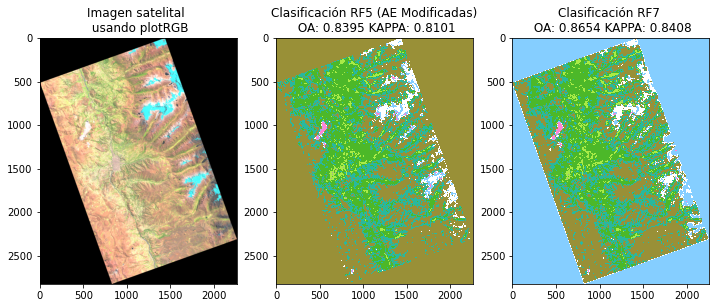

In [56]:
# Let´s plot
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 15))

# Imagen satelital
plotRGB(img, title = 'Imagen satelital \n usando plotRGB', ax = axes[0])

# RF Class 5
axes[1].imshow(rf_class5.get('Classification_Map'), cmap = palette)
axes[1].set_title("Clasificación RF5 (AE Modificadas)\n OA: 0.8395 KAPPA: 0.8101")
axes[1].grid(False)

# RF Class 7
axes[2].imshow(rf_class7.get('Classification_Map'), cmap = palette)
axes[2].set_title("Clasificación RF7 \n OA: 0.8654 KAPPA: 0.8408")
axes[2].grid(False)

In [57]:
from scikeo.writeRaster import writeRaster

In [58]:
# Guardando las imagenes clasificadas
writeRaster(arr = rf_class5.get('Classification_Map'), 
   image = img, 
   filename = '1Clas_RF5', 
   filepath = r"C:\Users\vale5\OneDrive\Documentos\Universidad\2022-2\Analisis\TRABF_ML_DL\Data\raster\Clasif_Fin",
   n = 1)
writeRaster(arr = rf_class7.get('Classification_Map'), 
   image = img, 
   filename = '2Clas_RF7', 
   filepath = r"C:\Users\vale5\OneDrive\Documentos\Universidad\2022-2\Analisis\TRABF_ML_DL\Data\raster\Clasif_Fin",
   n = 1)